In [3]:
#!chromosight quantify --pattern hairpins --threads=12 data/hairpins_25.bedpe data/wt.combined.MG1655.mapq30.25.cool hairpins.AGav

In [ ]:
# !chromosight detect --pattern hairpins --threads=4 --min-separation=200 data/wt.combined.MG1655.mapq30.25.mcool::/resolutions/25 data/hairpins_25 

In [5]:
import pandas as pd
import cooler
import cooltools
import bioframe as bf
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bootstrap
import seaborn as sns
# os.chdir('/home/fox/projects/ecoli_microc')
from textwrap import wrap
from matplotlib import font_manager

In [18]:
# colors
# Create an array with the colors you want to use
susielu = ["#b84873", "#6dbc5f","#5a3789","#bdab3d","#6d80d8","#bd7635","#bf68b8","#46c19a","#ba4b41","#71883b"] # Set your custom color palette
# susielu_pal = sns.set_palette(sns.color_palette(susielu))
susielu_greyscale = ["#636363", "#a4a4a4","#444444", "#a7a7a7", "#828282",] # Set your custom color palette
# susielu_greyscale_pal = sns.set_palette(sns.color_palette(susielu_greyscale))
susielu_accent = ["#636363", "#b84873", "#a4a4a4","#444444", "#a7a7a7", "#828282",] 
sns.set_theme(context="paper", style='whitegrid', palette=susielu) #, font="Arial"
cm = 1/2.54  # centimeters in inches

In [49]:
# %% hairpins
df = pd.read_excel('data/hairpins_Gavrilov.xlsx')
df
hairpins_df_bedpe = pd.DataFrame({
    'chrom1': 'NC_000913.3',
    'start1': df.wt_left//25*25,
    'end1': (df.wt_left//25+1)*25,
    'chrom2': 'NC_000913.3',
    'start2': df.wt_right//25*25,
    'end2': (df.wt_right//25+1)*25,
})
hairpins_df_bedpe.to_csv('data/hairpins_25.bedpe', sep='\t', index=False, header=False)

In [64]:
hairpins_df_Pseudobedpe = pd.DataFrame({
    'chrom1': 'NC_000913.3',
    'start1': df.wt_middle//25*25,
    'end1': (df.wt_middle//25+1)*25,
    'chrom2': 'NC_000913.3',
    'start2': df.wt_middle//25*25,
    'end2': (df.wt_middle//25+1)*25,
})

hairpins_df = pd.DataFrame({
    'chrom': 'NC_000913.3',
    'start': df.wt_middle//25*25,
    'end': (df.wt_middle//25+1)*25,
})
hairpins_df_Pseudobedpe.to_csv('data/hairpins_25.pseudo.bedpe', sep='\t', index=False, header=False)
# hairpins_df.to_csv('data/hairpins_25.bed', sep='\t', index=False, header=False)
hairpins_df.head()
# %% create bins
resolution = 50
clr = cooler.Cooler('data/wt.combined.MG1655.mapq30.25.mcool::resolutions/' + str(resolution))
df_chromsizes = clr.chromsizes
bins = cooler.binnify(df_chromsizes, 25)
bins.chrom = bins.chrom.astype(str)
fasta_records = bf.load_fasta('data/genome.fasta')
view_df_chromsizes = clr.chromsizes.reset_index()
view_df_chromsizes.columns = ['chrom', 'end']
view_df_chromsizes['start'] = 0
view_df_chromsizes['name'] = 'NC_000913.3'
view_df_chromsizes = view_df_chromsizes[['chrom', 'start', 'end', 'name']]

In [75]:
paired_sites = bf.pair_by_distance(hairpins_df, min_sep=200, max_sep=50000, suffixes=('1', '2'))

In [76]:
flank = 2_000
stack_paired = cooltools.pileup(clr, paired_sites, view_df=view_df_chromsizes, 
flank=flank, nproc=12, min_diag=4)
# stack = cooltools.pileup(clr, hairpins_df, view_df=view_df_chromsizes, 
                         # flank=flank, nproc=12, min_diag=8)
# Mirror reflect snippets when the feature is on the opposite strand
# mask = np.array(sites.strand == '-', dtype=bool)
# stack[:, :, mask] = stack[::-1, ::-1, mask]



INFO:root:creating a Pool of 12 workers
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:368: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:371: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region2_coords[0]
/home/izhegalova/.conda/envs/ecoli_microc/lib/python3.10/site-packages/cooltools/api/snipping.py:938: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `r

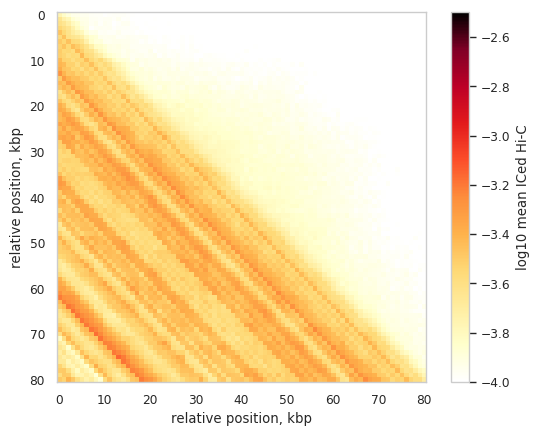

<Figure size 640x480 with 0 Axes>

In [78]:
# %%
# Aggregate. Note that some pixels might be converted to NaNs after IC, thus we aggregate by nanmean: 
mtx = np.nanmean(stack_paired, axis=0)

# Load colormap with large number of distinguishable intermediary tones,
# The "fall" colormap in cooltools is exactly for this purpose.
# After this step, you can use "fall" as cmap parameter in matplotlib:
import cooltools.lib.plotting

plt.imshow(
    np.log10(mtx),
    vmin = -4,
    vmax = -2.5,
    cmap='fall',
    interpolation='none')

plt.colorbar(label = 'log10 mean ICed Hi-C')
# ticks_pixels = np.linspace(0, flank*2//resolution,5)
# ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)
# plt.xticks(ticks_pixels, ticks_kbp)
# plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')
plt.grid(None)

# plt.savefig('results/hairpin_hic.median.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.clf()

In [79]:
#pup = coolpup.pileup(clr, pairs_df, features_format='bed', view_df=df_chromsizes, expected_df=expected, flip_negative_strand=True, mindist=5000, maxdist = 30_000, by_distance=[0, 30_000], flank=20_000, min_diag=0, nproc=4) #, groupby=['name1', 'name2']
#plotpup.plot(pup, score=True, cmap='coolwarm', scale='log', sym=True, vmax=1.2, vmin=0.8, height=3)

# ChIP-seq topo, pol & SMC

In [ ]:
#--source data/sequence.W3110.fasta --target data/genome.fasta
#data/topoI_rnaPol/GSM5514277_EcTopoI_1_peaks.narrowPeak

In [103]:
# SMC
chipseq_df = pd.read_csv('data/smc/GSE67221_MukB_37deg_20r_WTCTRL_peaks.txt', comment='#', sep="\t")
chipseq_df['chrom'] = 'NC_000913.3'
# chipseq_df['start'] = chipseq_df.Peak_start
# chipseq_df['end'] = chipseq_df.Peak_end
chipseq_df_cov = bf.coverage(bins, chipseq_df)
# chipseq_df_cov['frac'] = chipseq_df_cov.coverage / 25

bf.to_bigwig(df=chipseq_df_cov, chromsizes=df_chromsizes,
                        outpath='data/bw/%s.25.bw' % 'smc',
                        path_to_binary='/home/izhegalova/.conda/envs/omics_env/bin/bedGraphToBigWig')

CompletedProcess(args=['/home/izhegalova/.conda/envs/omics_env/bin/bedGraphToBigWig', '/scratch/tmp7oitgsgd.bg', '/scratch/tmp_o7kum6u.chrom.sizes', 'data/bw/smc.25.bw'], returncode=0, stdout=b'', stderr=b'')

In [ ]:
#topo-seq
# topo-seq/Un_IP_Mu_1_edt_for_rev_depth.wig - W3110

In [ ]:
#topoI
# W3110

In [105]:
# gapR
# NC_000913_2
# !wigToBigWig data/gapR/GSM4628311_D19-5504-3883G_norm.wig data/genome.chrom.sizes data/bw/gapR_1.bw
# !wigToBigWig data/gapR/GSM4628312_D19-11573-4278G_MG1655_norm.wig data/genome.chrom.sizes data/bw/gapR_2.bw

chromosome NC000913_2 is not in chrom sizes file


OSError: Not a bbi file: data/topo-seq/Un_IP_Mu_1_edt_for_rev_depth.wig

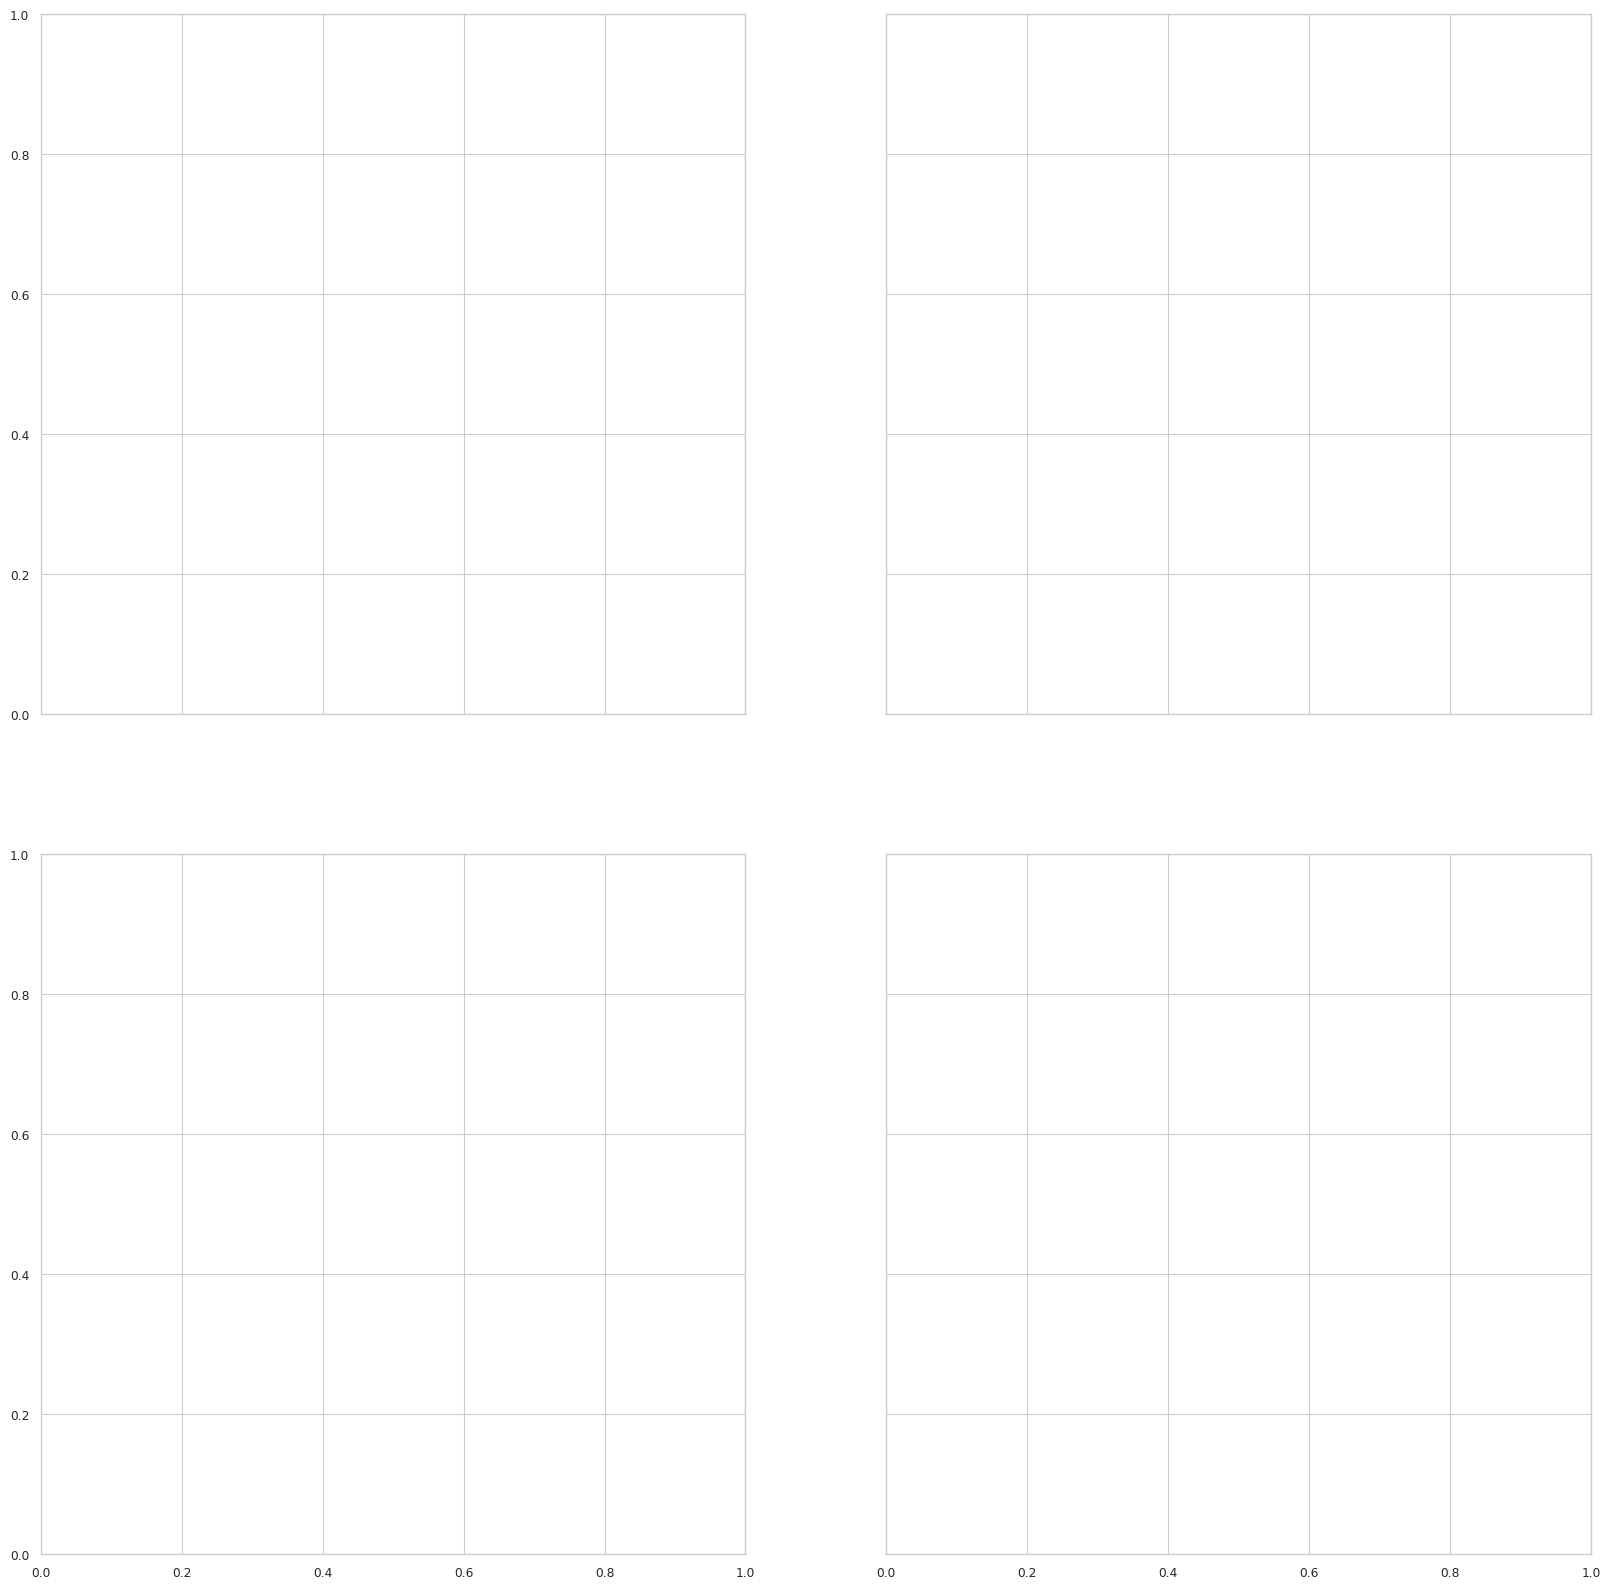

<Figure size 300x900 with 0 Axes>

In [84]:
bigwig_list = {'topo-seq1': 'topo-seq/Un_IP_Mu_1_edt_for_rev_depth.wig',
              'topo-seq2': 'topo-seq/Un_IP_Mu_2_edt_for_rev_depth.wig'}
import sys
sys.path.append('/home/izhegalova/ecoli_microc/scripts/')
from functions import plot_around_loop, wrapper_stackup
# %%
nbins=81
i=0
j=0
fig, axs = plt.subplots(2, 2,figsize=(20,20), 
sharex='all', sharey='all')
for id in bigwig_list.keys(): #337
    s_list, order = plot_around_loop(
        path_bw='data/%s' % bigwig_list[id],
        plot_name=None,
        nbins=81,
        resolution=25,
        chrom_file=df_chromsizes,
        window=1000,
        mode="mean",
        ymin=0,
        ymax=25,
        vmin=0,
        vmax=25,
        norm=False,
        fill=True,
        how_far_from_edge=40,
        bed_list=[
            "data/hairpins_25.bedpe",
        ],
        pic_path='results/',
        return_matrix=True
    )
    upper_median = np.nanmedian(s_list[0][order, :], axis=0)
    # tmp = sliding_window(seq=np.mean(s_list[i][order, :], axis=0), half_window_size=2)
    axs[i,j].set_title(id)
    axs[i,j].plot(upper_median)
    axs[i,j].set(xticklabels=[])
    axs[i,j].set_ylim([-1, 10])
    # err_style
    to_bootstrap = (s_list[0][order, :],)
    rng = np.random.default_rng()
    res = bootstrap(
    to_bootstrap,
    np.nanstd,
    n_resamples=100,
    confidence_level=0.9,  # vectorized=True,
    axis=0,
    random_state=rng,
    method="basic",
    )
    dyfit = res.standard_error

    axs[i,j].fill_between(
        range(nbins),
        upper_median - dyfit,
        upper_median + dyfit,
        color="blue",
        alpha=0.3,
    )
    i += 1
    if i == 10:
        i = 0
        j += 1
# fig.savefig('results/chipseq.map_mean.pdf', dpi=100, bbox_inches='tight')
fig.show()
fig.clf()

In [ ]:
import sys
sys.path.append('/home/fox/projects/dicty/hic_loop_study/scripts/functions/modules/')
from functions import plot_around_loop, wrapper_stackup
# %%
nbins=81
i=0
j=0
fig, axs = plt.subplots(10, 10,figsize=(20,20), 
sharex='all', sharey='all')
for id in range(242, 337): #337
    chipseq_df = pd.read_csv('data/chipseq/RHTECOLIBSD00%s.csv' % id, index_col=0)
    s_list, order = plot_around_loop(
        path_bw='data/bw/%s.25.bw' % chipseq_df['TF_name*'][0],
        plot_name=chipseq_df['TF_name*'][0],
        nbins=81,
        resolution=25,
        chrom_file=df_chromsizes,
        window=1000,
        mode="mean",
        ymin=0,
        ymax=25,
        vmin=0,
        vmax=25,
        norm=False,
        fill=True,
        how_far_from_edge=40,
        bed_list=[
            "data/hairpins_25.bedpe",
        ],
        pic_path='results/',
        return_matrix=True
    )
    upper_median = np.nanmedian(s_list[0][order, :], axis=0)
    # tmp = sliding_window(seq=np.mean(s_list[i][order, :], axis=0), half_window_size=2)
    axs[i,j].set_title(chipseq_df['TF_name*'][0])
    axs[i,j].plot(upper_median)
    axs[i,j].set(xticklabels=[])
    axs[i,j].set_ylim([-1, 10])
    # err_style
    to_bootstrap = (s_list[0][order, :],)
    rng = np.random.default_rng()
    res = bootstrap(
    to_bootstrap,
    np.nanstd,
    n_resamples=100,
    confidence_level=0.9,  # vectorized=True,
    axis=0,
    random_state=rng,
    method="basic",
    )
    dyfit = res.standard_error

    axs[i,j].fill_between(
        range(nbins),
        upper_median - dyfit,
        upper_median + dyfit,
        color="blue",
        alpha=0.3,
    )
    i += 1
    if i == 10:
        i = 0
        j += 1
fig.savefig('results/chipseq.map_mean.pdf', dpi=100, bbox_inches='tight')
fig.show()
fig.clf()